In [1]:
import cvxopt
import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from utils import (
    get_all_atom_types,
    clean_dataset,
    WLK_linear,
    WLK_dist,
    WL,
    nth_order_walk,
    weisfeiler_lehman,
    KernelSVC,
    stratified_cross_val
)

In [2]:
cvxopt.solvers.options['show_progress'] = False

Reading the data:

In [3]:
with open('data/training_data.pkl', 'rb') as file:
    train_graphs = pkl.load(file)

with open('data/test_data.pkl', 'rb') as file:
    test_graphs = pkl.load(file)

with open('data/training_labels.pkl', 'rb') as file:
    train_labels = pkl.load(file)

Cleaning the data:

In [4]:
train_graphs, train_labels = clean_dataset(train_graphs, train_labels)
test_graphs, _ = clean_dataset(test_graphs, np.zeros(2000), discard=False)

Plotting the data:

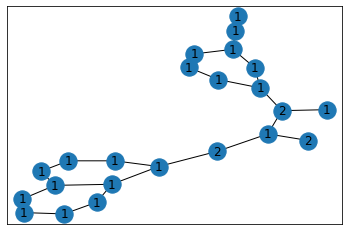

In [5]:
idx=1
nx.draw_networkx(train_graphs[idx], labels=get_all_atom_types(train_graphs[idx]))

## Building the Gram Matrix

### Walk kernel Gram Matrix:

In [6]:
# n = 3

# N_train = len(train_graphs)
# indexes_train = np.arange(N_train)

# N_test = len(test_graphs)
# indexes_test = np.arange(N_test)

# G_train = np.zeros((N_train, N_train))
# for i in tqdm(range(N_train)):
#     for j in range(i, N_train):
#         g = nth_order_walk(train_graphs[i], train_graphs[j])
#         G_train[i,j] = g
#         G_train[j,i] = g

### Weisfeiler Lehman (WL) Gram Matrix:

Explicit features computation:

In [8]:
# h = 3
max_iter = 2

N_train = len(train_graphs)
indexes_train = np.arange(N_train)

N_test = len(test_graphs)
indexes_test = np.arange(N_test)

X_train = []
for i in indexes_train:
    #X_train.append(weisfeiler_lehman(train_graphs[i], h=h))
    X_train.append(WL(train_graphs[i], max_iter=max_iter))

X_test = []
for i in indexes_test:
    #X_test.append(weisfeiler_lehman(test_graphs[i], h=h))
    X_test.append(WL(test_graphs[i], max_iter=max_iter))

#### Linear Kernel:

In [9]:
# G_train_lin = np.zeros((N_train, N_train))
# for i in tqdm(range(N_train)):
#     for j in range(i, N_train):
#         g = WLK_linear(X_train[i], X_train[j])
#         G_train_lin[i,j] = g
#         G_train_lin[j,i] = g

In [10]:
# # Matrix normalization:
# Norm = np.zeros((N_train, N_train))
# for i in tqdm(range(N_train)):
#     for j in range(i, N_train):
#         n = np.sqrt(G_train_lin[i,i]*G_train_lin[j,j])
#         Norm[i,j] = n
#         Norm[j,i] = n

# G_train_lin = np.divide(G_train_lin, Norm)

In [11]:
# G_test_lin = np.zeros((N_test, N_train))
# for i in tqdm(range(N_test)):
#     for j in range(N_train):
#         G_test_lin[i,j] = WLK_linear(X_test[i], X_train[j]) # / np.sqrt(WLK_linear(X_test[i], X_test[i]) * WLK_linear(X_train[j], X_train[j]))

#### RBF Kernel:

Squared euclidean distance:

In [12]:
G_train_dist = np.zeros((N_train, N_train))
for i in tqdm(range(N_train)):
    for j in range(i, N_train):
        g = WLK_dist(X_train[i], X_train[j])
        G_train_dist[i,j] = g
        G_train_dist[j,i] = g

100%|██████████| 5774/5774 [04:08<00:00, 23.25it/s] 


In [13]:
G_test_dist = np.zeros((N_test, N_train))
for i in tqdm(range(N_test)):
    for j in range(N_train):
        G_test_dist[i,j] = WLK_dist(X_test[i], X_train[j])

100%|██████████| 2000/2000 [02:31<00:00, 13.17it/s]


RBF Kernel:

In [14]:
# sigma = 4.
# G_train_rbf = np.exp(-0.5*G_train_dist/(sigma**2))
# G_test_rbf = np.exp(-0.5*G_test_dist/(sigma**2))

## SVM with Cross Validation:

Cross validation:

In [15]:
sigma = 4.
G_train_rbf = np.exp(-0.5*G_train_dist/(sigma**2))
G_test_rbf = np.exp(-0.5*G_test_dist/(sigma**2))

In [16]:
C = 0.5
class_weights={-1:1, 1:10}

models, scores, test_preds = stratified_cross_val(
    n_fold=5,
    G_train=G_train_rbf,
    train_labels=train_labels,
    G_test=G_test_rbf,
    C=C,
    class_weights=class_weights,
    verbose=True,
    seed=42
)

print(np.mean(scores))

y_test_pred = np.mean(test_preds, axis=0)

##### 5-FOLD CROSS VAL: starting fold 1 #####
Percentage of positive values: 9.439273%%
Val score: 0.9180232252179558
##### 5-FOLD CROSS VAL: starting fold 2 #####
Percentage of positive values: 9.439273%%
Val score: 0.9047134562422159
##### 5-FOLD CROSS VAL: starting fold 3 #####
Percentage of positive values: 9.439273%%
Val score: 0.9049371129861246
##### 5-FOLD CROSS VAL: starting fold 4 #####
Percentage of positive values: 9.439273%%
Val score: 0.9296665321802585
##### 5-FOLD CROSS VAL: starting fold 5 #####
Percentage of positive values: 9.437229%%
Val score: 0.9097756902682058
0.9134232033789521


## Grid search:

In [15]:
sigmas = [2., 4., 6., 8.]
Cs = [0.5, 1., 2., 4.]
y_weights = [False, {-1:1, 1:5}, {-1:1, 1:10}]

results = []

best_score = 0
y_test_pred = np.zeros(2000)

for sigma in sigmas:
    print(f'#### sigma = {sigma} ####')
    G_train_rbf = np.exp(-0.5*G_train_dist/(sigma**2))
    G_test_rbf = np.exp(-0.5*G_test_dist/(sigma**2))

    for C in tqdm(Cs):
        models, scores, test_preds = stratified_cross_val(
            G_train=G_train_rbf,
            train_labels=train_labels,
            G_test=G_test_rbf,
            C=C,
            class_weights=False,
            seed=42,
            verbose=False,
            n_fold=6
        )

        mean_score = np.mean(scores)

        parameters = {
            'h':3,
            'class_weights':False,
            'clean_data':False,
            'sigma':sigma,
            'C':C,
            'mean_score':mean_score
        }

        results.append(parameters)

        if mean_score > best_score:
            best_score = mean_score
            y_test_pred = np.mean(test_preds, axis=0)
            print(f'New best model \n   sigma = {sigma}, C = {C} \n   score = {mean_score}')

dataframe = pd.DataFrame(results)
dataframe.to_csv('grid_search_results_4.csv')

#### sigma = 2.0 ####


 25%|██▌       | 1/4 [08:35<25:46, 515.40s/it]

New best model 
   sigma = 2.0, C = 0.5 
   score = 0.8378771616277354


 75%|███████▌  | 3/4 [22:45<07:40, 460.09s/it]

New best model 
   sigma = 2.0, C = 2.0 
   score = 0.8400567177389878


100%|██████████| 4/4 [26:49<00:00, 402.32s/it]

New best model 
   sigma = 2.0, C = 4.0 
   score = 0.8402263643312265
#### sigma = 4.0 ####



 25%|██▌       | 1/4 [04:25<13:15, 265.21s/it]

New best model 
   sigma = 4.0, C = 0.5 
   score = 0.8481088465295857


 50%|█████     | 2/4 [08:41<08:45, 262.63s/it]

New best model 
   sigma = 4.0, C = 1.0 
   score = 0.8492828323522189


 75%|███████▌  | 3/4 [12:56<04:20, 260.15s/it]

New best model 
   sigma = 4.0, C = 2.0 
   score = 0.852770030939706


100%|██████████| 4/4 [17:17<00:00, 259.25s/it]


#### sigma = 6.0 ####


100%|██████████| 4/4 [17:52<00:00, 268.19s/it]

New best model 
   sigma = 6.0, C = 4.0 
   score = 0.857662837055349
#### sigma = 8.0 ####



100%|██████████| 4/4 [19:32<00:00, 293.08s/it]


In [48]:
df = pd.read_csv('/home/eugene/code/mva-kernel/grid_search_results_3.csv')
#df = df[df['class_weights']=='False']

<AxesSubplot:xlabel='C', ylabel='sigma'>

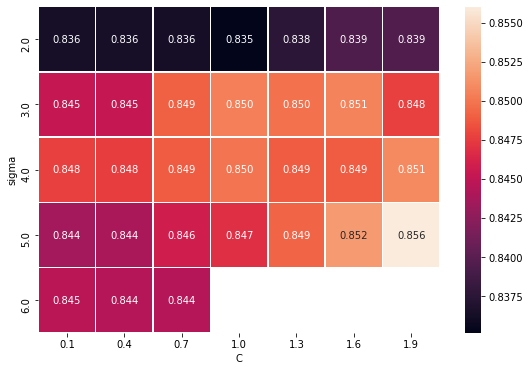

In [49]:
# Load the example flights dataset and convert to long-form
table = df.pivot("sigma", "C", "mean_score")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(table, annot=True, fmt='.3f', linewidths=.5, ax=ax)

In [50]:
sigma = 4.0
C = 1.0

G_train_rbf = np.exp(-0.5*G_train_dist/(sigma**2))
G_test_rbf = np.exp(-0.5*G_test_dist/(sigma**2))

models, scores, test_preds = cross_val(
    G_train=G_train_rbf,
    train_labels=train_labels,
    G_test=G_test_rbf,
    C=C,
    class_weights=True,
    seed=42,
    verbose=True,
    n_fold=4
)

print(np.mean(scores))

##### 5-FOLD CROSS VAL: starting fold 1 #####
Val score: 0.8345015941485371
##### 5-FOLD CROSS VAL: starting fold 2 #####
Val score: 0.8437944085658406
##### 5-FOLD CROSS VAL: starting fold 3 #####
Val score: 0.8249468301733112
##### 5-FOLD CROSS VAL: starting fold 4 #####
Val score: 0.86
0.8408107082219222


In [28]:
y_test_pred = np.mean(test_preds, axis=0)

#### Fitting kNN:

In [ ]:
# def kNN(G_val, y_train, k=3):
#     """
#     Given a feature dictionnary whose label is to be predicted, the WL feature vector of the graphs in the training set 
#     and the number of nearest neighbors k, returns the predicted label of G.
#     """
#     neighbours = np.argpartition(G_val, k, axis=1)[:,:k]

#     y_pred = []
#     for i in range(len(neighbours)):
#         is_positive = sum([y_train[i] for i in neighbours[i]])
#         if is_positive > k/2 :
#             y_pred.append(1)
#         else:
#             y_pred.append(0)
#     return np.array(y_pred)

In [ ]:
# y_pred = kNN(G_val, y_train, k=1)

# cm = confusion_matrix(y_val, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
# disp.plot()
# plt.show()

# y_pred.sum()/len(y_pred)

## Submission:

In [25]:
Yte = {'Predicted' : np.array(y_test_pred, dtype=np.float32)}
dataframe = pd.DataFrame(Yte)
dataframe.index += 1
dataframe.to_csv('test_pred.csv', index_label='Id')